# Practice: Convolutional Neural Networks (CNNs)
In this practice, we demonstrate how to implement CNNs. We use the `Python` `torch` package for our implementations.
PyTorch is a well-structured, flexible library that will feel comfortable
to `Python` users. A good companion is the official PyTorch tutorials site:
[pytorch.org/tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html).
Much of our code is adapted from there.


In [1]:
import numpy as np, pandas as pd

### Torch-Specific Imports
There are a number of imports for `torch`.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


There are several other helper packages for `torch`. The `torchinfo` package provides a useful
summary of the layers of a model. We use the `read_image()`
function when loading test images.

In [3]:
# It is possible that we need to install torchmetrics and torchinfo
# pip install torchmetrics torchinfo

In [4]:
from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary


We will use several datasets shipped with `torchvision` for our
examples: a pretrained network for image classification,
as well as some transforms used for preprocessing.

In [5]:
from torchvision.io import read_image
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)

Finally, we introduce some utility imports  not directly related to
`torch`.
The `glob()` function from the `glob` module is used
to find all files matching wildcard characters, which we will use
in our example applying the `ResNet50` model
to some of our own images.
The `json` module will be used to load
a JSON file for looking up classes to identify the labels of the
pictures in the `ResNet50` example.

In [6]:
from glob import glob
import json


## Convolutional Neural Networks
In this section we fit a CNN to the `CIFAR100` data, which is available in the `torchvision`
package. It is arranged in a similar fashion as the `MNIST` data.

In [7]:
from torchvision.datasets import CIFAR100
cifar_train = CIFAR100(root=".data", train=True, transform=ToTensor(), download=True)
cifar_test = CIFAR100(root=".data", train=False, transform=ToTensor(), download=True)

In [8]:
y_train = np.array(cifar_train.targets)
y_test = np.array(cifar_test.targets)

print(y_train[:5])

[19 29  0 11  1]


The `CIFAR100` dataset consists of 50,000 training images, each represented by a three-dimensional tensor:
each three-color image is represented as a set of three channels, each of which consists of
$32\times 32$ eight-bit pixels. We standardize as we did for the
digits, but keep the array structure. This is accomplished with the `ToTensor()` transform.



We again look at the shape of typical batches in our data loaders.

Before we start, we look at some of the training images; similar code produced
Figure 10.5 on page  447. The example below also illustrates
that `TensorDataset` objects can be indexed with integers --- we are choosing
random images from the training data by indexing `cifar_train`. In order to display correctly,
we must reorder the dimensions by a call to `np.transpose()`.

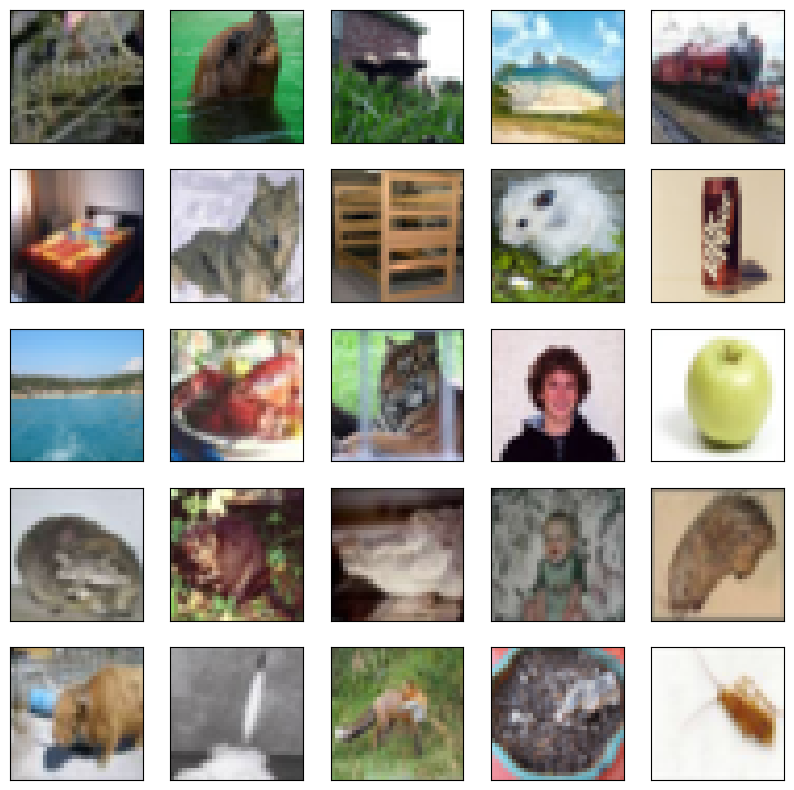

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 5, figsize=(10,10))
rng = np.random.default_rng(4)
indices = rng.choice(np.arange(len(cifar_train)), 25,
                     replace=False).reshape((5,5))
for i in range(5):
    for j in range(5):
        idx = indices[i,j]
        axes[i,j].imshow(np.transpose(cifar_train[idx][0],
                                      [1,2,0]),
                                      interpolation=None)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])


Here the `imshow()` method recognizes from the shape of its argument that it is a 3-dimensional array, with the last dimension indexing the three RGB color channels.

We specify a moderately-sized  CNN for
demonstration purposes, similar in structure to Figure 10.8.
We use several layers, each consisting of  convolution, ReLU, and max-pooling steps.
We first define a module that defines one of these layers. As in our
previous examples, we overwrite the `__init__()` and `forward()` methods
of `nn.Module`. This user-defined  module can now be used in ways just like
`nn.Linear()` or `nn.Dropout()`.

In [10]:
class BuildingBlock(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels):

        super(BuildingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=(3,3),
                              padding='same')
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2,2))

    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))


Notice that we used the `padding = "same"` argument to
`nn.Conv2d()`, which ensures that the output channels have the
same dimension as the input channels. There are 32 channels in the first
hidden layer, in contrast to the three channels in the input layer. We
use a $3\times 3$ convolution filter for each channel in all the layers. Each
convolution is followed by a max-pooling layer over $2\times2$
blocks.

In forming our deep learning model for the `CIFAR100` data, we use several of our `BuildingBlock()`
modules sequentially. This simple example
illustrates some of the power of `torch`. Users can
define modules of their own, which can be combined in other
modules. Ultimately, everything is fit by a generic trainer.

In [11]:
class CIFARModel(nn.Module):

    def __init__(self):
        super(CIFARModel, self).__init__()
        sizes = [(3,32),
                 (32,64),
                 (64,128),
                 (128,256)]
        self.conv = nn.Sequential(*[BuildingBlock(in_, out_)
                                    for in_, out_ in sizes])

        self.output = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(2*2*256, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 100))
    def forward(self, x):
        val = self.conv(x)
        val = torch.flatten(val, start_dim=1)
        return F.softmax(self.output(val), dim=-1)

We  build the model and look at the summary.

In [20]:
cifar_model = CIFARModel()

In [13]:
from torch.utils.data import DataLoader

# Assuming cifar_train is a Dataset object
train_loader = DataLoader(cifar_train, batch_size=1, shuffle=False)
# Get a single batch of data
inputs, _ = next(iter(train_loader))

summary(cifar_model,
        input_data=inputs,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CIFARModel                               [1, 3, 32, 32]            [1, 100]                  --
├─Sequential: 1-1                        [1, 3, 32, 32]            [1, 256, 2, 2]            --
│    └─BuildingBlock: 2-1                [1, 3, 32, 32]            [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-1                  [1, 3, 32, 32]            [1, 32, 32, 32]           896
│    │    └─ReLU: 3-2                    [1, 32, 32, 32]           [1, 32, 32, 32]           --
│    │    └─MaxPool2d: 3-3               [1, 32, 32, 32]           [1, 32, 16, 16]           --
│    └─BuildingBlock: 2-2                [1, 32, 16, 16]           [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-4                  [1, 32, 16, 16]           [1, 64, 16, 16]           18,496
│    │    └─ReLU: 3-5                    [1, 64, 16, 16]           [1, 64, 16, 16]           --
│    │    └─MaxPool2d: 3-6    

The total number of trainable parameters is 964,516.

By studying the size of the parameters, we can see that the channels halve in both dimensions after each of these max-pooling operations. After the last of these we have a layer with 256 channels of dimension 2x2. These are then flattened to a dense layer of size 1,024; in other words, each of the 2x2 matrices is turned into a 4-vector, and put side-by-side in one layer. This is followed by a dropout regularization layer, then
another dense layer of size 512, and finally, the output layer.

For these data, experiments show that a smaller learning rate performs better than larger values. We'll use a learning rate of 0.001 when defining
our optimizer. The optimizer takes the model's parameters as an argument, which informs it which parameters are involved in the optimization process.

We'll use stochastic gradient descent (SGD) as our optimization algorithm. The training process will follow a similar pattern to our previous examples, where we iterate over epochs and batches, perform forward and backward passes, and update the model's parameters.

When we pass the model's parameters to the optimizer, we're doing more than simply passing arrays; we're also passing the computational graph structure that PyTorch uses for automatic differentiation. This allows the optimizer to correctly compute and apply gradients during the training process.


In [14]:
# First cell - Imports
import time
from tqdm.notebook import tqdm  # Special tqdm version for Jupyter notebooks

####  Model Training

To train our model, we will use the `train_model` function. This function is designed to be quite general and can be used for training various types of neural networks. Here's how we'll proceed with the training:

1. Define the model architecture (already done in the previous cell).
2. Set up the loss function and optimizer.
3. Prepare the data loaders for training and validation sets.
4. Call the `train_model` function with the necessary parameters.

The `train_model` function typically handles the following tasks:
- Iterating through the specified number of epochs
- Performing forward and backward passes
- Updating model parameters
- Computing and logging training and validation losses
- Saving the best model based on validation performance

Let's proceed with setting up the training process:


In [22]:
def train_model(
    model,
    train_loader,
    optimizer,
    criterion=None,
    valid_loader=None,
    epochs=30,
    device='cuda'
):
    """
    A general training function for PyTorch models.
    
    Parameters:
    -----------
    model : torch.nn.Module
        The neural network model to train
    train_loader : torch.utils.data.DataLoader
        DataLoader for training data
    optimizer : torch.optim.Optimizer
        Optimizer for training
    criterion : torch.nn.Module, optional
        Loss function (defaults to CrossEntropyLoss if None)
    valid_loader : torch.utils.data.DataLoader, optional
        DataLoader for validation data
    epochs : int
        Number of training epochs
    device : str
        'cuda' or 'cpu'
    
    Returns:
    --------
    dict
        Training history containing losses and accuracies
    """
    model = model.to(device)
    
    if criterion is None:
        criterion = torch.nn.CrossEntropyLoss()
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': []
    }
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()
        
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100. * correct_train / total_train
        
        if valid_loader is not None:
            model.eval()
            valid_loss = 0.0
            correct_valid = 0
            total_valid = 0
            
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    valid_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total_valid += labels.size(0)
                    correct_valid += predicted.eq(labels).sum().item()
            
            epoch_valid_loss = valid_loss / len(valid_loader)
            epoch_valid_acc = 100. * correct_valid / total_valid
            
            history['valid_loss'].append(epoch_valid_loss)
            history['valid_acc'].append(epoch_valid_acc)
        
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        if valid_loader is not None:
            print(f'Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_acc:.2f}%')
        print('-' * 50)
    
    return history


In [23]:
# Define dataloaders first

BATCH_SIZE = 1024 # originally 256

train_loader = DataLoader(cifar_train, batch_size=BATCH_SIZE, shuffle=True) # batch_size=256

test_loader = DataLoader(cifar_test, batch_size=BATCH_SIZE, shuffle=False) # batch_size=256

# Define optimizer
optimizer = torch.optim.AdamW(cifar_model.parameters(), lr=0.001)

# Training
history = train_model(
    model=cifar_model,
    train_loader=train_loader,
    optimizer=optimizer,
    valid_loader=test_loader,  # or test_loader if you want validation
    epochs=30,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

Epoch 1/30:
Train Loss: 4.5623, Train Acc: 5.90%
Valid Loss: 4.5497, Valid Acc: 7.30%
--------------------------------------------------
Epoch 2/30:
Train Loss: 4.5505, Train Acc: 7.05%
Valid Loss: 4.5439, Valid Acc: 7.73%
--------------------------------------------------
Epoch 3/30:
Train Loss: 4.5442, Train Acc: 7.77%
Valid Loss: 4.5395, Valid Acc: 8.20%
--------------------------------------------------
Epoch 4/30:
Train Loss: 4.5435, Train Acc: 7.80%
Valid Loss: 4.5365, Valid Acc: 8.50%
--------------------------------------------------
Epoch 5/30:
Train Loss: 4.5377, Train Acc: 8.41%
Valid Loss: 4.5333, Valid Acc: 8.91%
--------------------------------------------------
Epoch 6/30:
Train Loss: 4.5349, Train Acc: 8.70%
Valid Loss: 4.5315, Valid Acc: 9.10%
--------------------------------------------------
Epoch 7/30:
Train Loss: 4.5292, Train Acc: 9.31%
Valid Loss: 4.5295, Valid Acc: 9.22%
--------------------------------------------------
Epoch 8/30:
Train Loss: 4.5290, Train Acc

This model can take 10 minutes or more to run and achieves about 42% accuracy on the test
data. Although this is not terrible for 100-class data (a random
classifier gets 1% accuracy), searching the web we see results around
75%. Typically it takes a lot of architecture carpentry,
fiddling with regularization, and time, to achieve such results.

Let’s take a look at the validation and training accuracy
across epochs.

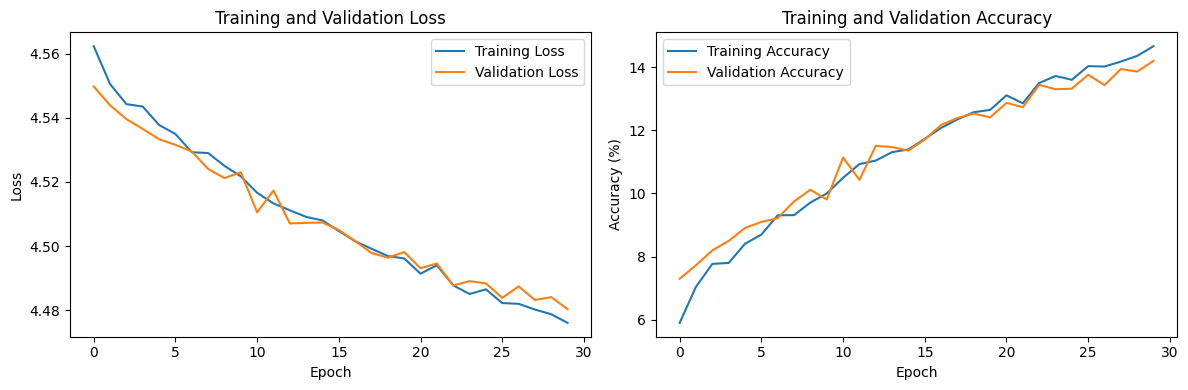

In [24]:
# Fourth cell - Visualize training results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
if 'valid_loss' in history and history['valid_loss']:
    plt.plot(history['valid_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
if 'valid_acc' in history and history['valid_acc']:
    plt.plot(history['valid_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Finally, we evaluate our model on our test data.

In [25]:
def evaluate_model(
    model,
    test_loader,
    criterion=None,
    device='cuda'
):
    """
    A general evaluation function for PyTorch models.
    
    Parameters:
    -----------
    model : torch.nn.Module
        The neural network model to evaluate
    test_loader : torch.utils.data.DataLoader
        DataLoader for test data
    criterion : torch.nn.Module, optional
        Loss function (defaults to CrossEntropyLoss if None)
    device : str
        'cuda' or 'cpu'
    
    Returns:
    --------
    tuple
        (test_accuracy, test_loss)
    """
    # Set model to evaluation mode
    model.eval()
    
    # Set default criterion if none provided
    if criterion is None:
        criterion = torch.nn.CrossEntropyLoss()
    
    correct = 0
    total = 0
    test_loss = 0.0
    
    # Disable gradient computation for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move data to device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Update loss
            test_loss += loss.item()
            
            # Get predictions
            _, predicted = outputs.max(1)
            
            # Update statistics
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    # Calculate metrics
    test_accuracy = correct / total
    test_loss = test_loss / len(test_loader)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    
    return test_accuracy, test_loss


In [26]:

# Testing
test_accuracy, test_loss = evaluate_model(
    model=cifar_model,
    test_loader=test_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

Test Loss: 4.4803
Test Accuracy: 0.14%


## Using Pretrained CNN Models

We now show how to use a CNN pretrained on the  `imagenet` database to classify natural images.
We copied six JPEG images from a digital photo album into the directory `example_images`. 

The pretrained network we use is called `resnet18`; specification details can be found on the web.
We will read in the images, and convert them into the array format expected by the `torch` software to match the specifications in `resnet18`. 

The conversion involves a resize, a crop and then a predefined standardization for each of the three channels.
We now read in the images and preprocess them.

![](resnet18.png)

### Residual Block in ResNet


A residual block in ResNet is designed to address the degradation problem in deep neural networks.

Key features:
1. Skip connection: Allows the input to bypass the main path
2. Main path: Contains convolutional layers and activation functions

Purpose:
- Enables training of very deep networks
- Mitigates the vanishing gradient problem
- Allows the network to learn residual functions

How it works:
1. Input x is fed into the main path and the skip connection
2. Main path applies transformations: F(x)
3. Skip connection passes x unchanged
4. Output: y = F(x) + x

Benefits:
- Easier optimization: Network can choose to use or ignore the residual path
- Improved gradient flow: Gradients can flow directly through skip connections
- Better performance: Allows for much deeper architectures without performance degradation

In essence, residual blocks make it easier for the network to learn identity mappings,
which is crucial for maintaining performance as network depth increases.
"""

##### Example of a basic residual block

```python
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)  # Skip connection
        out = F.relu(out)
        return out
```


In [49]:
resize = Resize((232,232), antialias=True)
crop = CenterCrop(224)
normalize = Normalize([0.485,0.456,0.406],
                      [0.229,0.224,0.225])
imgfiles = sorted([f for f in glob('example_images/*.jpg')])
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255)
                    for f in imgfiles])
imgs = normalize(imgs)
imgs.size()


torch.Size([6, 3, 224, 224])

We now set up the trained network with the weights of the ResNet18 model. The model has 18 layers, with a fair bit of complexity.

In [51]:
from torchvision.models import (resnet18,
                                ResNet18_Weights)

resnet_model = resnet18(weights=ResNet18_Weights.DEFAULT)
summary(resnet_model,
        input_data=imgs,
        col_names=['input_size',
                   'output_size',
                   'num_params'])


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:02<00:00, 17.7MB/s]


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [6, 3, 224, 224]          [6, 1000]                 --
├─Conv2d: 1-1                            [6, 3, 224, 224]          [6, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [6, 64, 112, 112]         [6, 64, 112, 112]         128
├─ReLU: 1-3                              [6, 64, 112, 112]         [6, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [6, 64, 112, 112]         [6, 64, 56, 56]           --
├─Sequential: 1-5                        [6, 64, 56, 56]           [6, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [6, 64, 56, 56]           [6, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [6, 64, 56, 56]           [6, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [6, 64, 56, 56]           [6, 64, 56, 56]           128
│    │    └─ReLU: 3-3     

We set the mode to `eval()` to ensure that the model is ready to predict on new data.

In [ ]:
resnet_model.eval()

Inspecting the output above, we see that when setting up the
`resnet_model`, the authors defined a `Bottleneck`, much like our
`BuildingBlock` module.

We now feed our six images through the fitted network.

In [ ]:
img_preds = resnet_model(imgs)
img_preds


Let’s look at the predicted probabilities for each of the top 3 choices. First we compute
the probabilities by applying the softmax to the logits in `img_preds`. Note that
we have had to call the `detach()` method on the tensor `img_preds` in order to convert
it to our a more familiar `ndarray`.

In [54]:
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:,None]


In order to see the class labels, we must download the index file associated with `imagenet`.

In [56]:
labs = json.load(open('example_images/imagenet_class_index.json'))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in 
                           labs.items()],
                           columns=['idx', 'label'])
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()


We’ll now construct a data frame for each image file
with the labels with the three highest probabilities as
estimated by the model above.

In [59]:
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:3]
    print(f'Image: {imgfile}')
    print(img_df.reset_index().drop(columns=['idx']))
    print("\n")


Image: example_images/Cape_Weaver.jpg
         label      prob
0     lorikeet  0.404938
1    bee_eater  0.190225
2  hummingbird  0.095605


Image: example_images/Flamingo.jpg
         label      prob
0     flamingo  0.981864
1    spoonbill  0.014318
2  black_stork  0.001941


Image: example_images/Hawk_Fountain.jpg
            label      prob
0            kite  0.184780
1             eel  0.134377
2  great_grey_owl  0.091476


Image: example_images/Hawk_cropped.jpg
     label      prob
0     kite  0.729876
1      jay  0.078307
2  vulture  0.023305


Image: example_images/Lhasa_Apso.jpg
             label      prob
0            Lhasa  0.834095
1         Shih-Tzu  0.100105
2  Tibetan_terrier  0.029907


Image: example_images/Sleeping_Cat.jpg
                  label      prob
0              Shih-Tzu  0.247174
1  Bernese_mountain_dog  0.217870
2         Saint_Bernard  0.134591




In [58]:
img_df

label      prob
idx                                
155              Shih-Tzu  0.247174
239  Bernese_mountain_dog  0.217870
247         Saint_Bernard  0.134591

## Finetuning (Transfer Learning)



In [72]:
# Import required libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import resnet18, ResNet18_Weights

from tqdm import tqdm
import matplotlib.pyplot as plt


# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [73]:
# Load pre-trained ResNet18 model with updated API

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)  # CIFAR100 has 100 classes

# Ensure the final layer is trainable
for param in model.fc.parameters():
    param.requires_grad = True


In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [75]:

# Load datasets
cifar_train = datasets.CIFAR100(root='.data', train=True, transform=transform, download=True)
cifar_test = datasets.CIFAR100(root='.data', train=False, transform=transform, download=True)

BATCH_SIZE = 512 # originally 128

# Create data loaders
train_loader = DataLoader(cifar_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(cifar_test, batch_size=BATCH_SIZE, shuffle=False)


In [76]:

# First phase: Train only the final layer
optimizer_phase1 = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

print("Phase 1: Training only the final layer...")
history_phase1 = train_model(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer_phase1,
    valid_loader=test_loader,
    epochs=1,
    device=device)


Phase 1: Training only the final layer...


Epoch 1/1 [Valid]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s, loss=2.66, acc=43.6]


Epoch 1/1:
Train Loss: 3.5824, Train Acc: 24.97%
Valid Loss: 2.6607, Valid Acc: 43.61%
--------------------------------------------------


In [77]:
# Second phase: Fine-tune all layers
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# New optimizer for all parameters with a lower learning rate
optimizer_phase2 = torch.optim.AdamW(model.parameters(), lr=0.001)

print("\nPhase 2: Fine-tuning all layers...")
history_phase2 = train_model(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer_phase2,
    valid_loader=test_loader,
    epochs=2,
    device=device)


Phase 2: Fine-tuning all layers...


Epoch 1/5 [Valid]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s, loss=1.21, acc=64.9] 



Epoch 1/5:
Train Loss: 1.2190, Train Acc: 64.95%
Valid Loss: 1.2103, Valid Acc: 64.88%
--------------------------------------------------


Epoch 2/5 [Valid]: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s, loss=1.06, acc=69.4] 



Epoch 2/5:
Train Loss: 0.6351, Train Acc: 80.92%
Valid Loss: 1.0625, Valid Acc: 69.39%
--------------------------------------------------


Epoch 3/5 [Valid]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s, loss=1.06, acc=69.9] 



Epoch 3/5:
Train Loss: 0.3613, Train Acc: 89.10%
Valid Loss: 1.0558, Valid Acc: 69.93%
--------------------------------------------------


Epoch 4/5 [Valid]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s, loss=1.06, acc=71.5] 



Epoch 4/5:
Train Loss: 0.1950, Train Acc: 94.40%
Valid Loss: 1.0571, Valid Acc: 71.45%
--------------------------------------------------


Epoch 5/5 [Valid]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s, loss=0.991, acc=73.6]


Epoch 5/5:
Train Loss: 0.1040, Train Acc: 97.21%
Valid Loss: 0.9909, Valid Acc: 73.57%
--------------------------------------------------


| Epoch | Phase  | Loss   | Accuracy (%) | Time      | Speed    |
|-------|--------|--------|--------------|-----------|----------|
| 1/5   | Train  | 1.2190 | 64.95        | 01:17     | 1.26 it/s|
| 1/5   | Valid  | 1.2103 | 64.88        | 00:10     | 1.92 it/s|
| 2/5   | Train  | 0.6351 | 80.92        | 01:17     | 1.26 it/s|
| 2/5   | Valid  | 1.0625 | 69.39        | 00:10     | 1.93 it/s|
| 3/5   | Train  | 0.3613 | 89.10        | 01:18     | 1.25 it/s|
| 3/5   | Valid  | 1.0558 | 69.93        | 00:10     | 1.91 it/s|
| 4/5   | Train  | 0.1950 | 94.40        | 01:18     | 1.25 it/s|
| 4/5   | Valid  | 1.0571 | 71.45        | 00:10     | 1.92 it/s|
| 5/5   | Train  | 0.1040 | 97.21        | 01:18     | 1.26 it/s|
| 5/5   | Valid  | 0.9909 | 73.57        | 00:10     | 1.91 it/s|

In [78]:
# Evaluate final model
test_accuracy, test_loss = evaluate_model(
    model=model,
    test_loader=test_loader,
    device=device
)

Testing: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]

Test Loss: 0.9909
Test Accuracy: 0.74%


# Exercises

1. Change the criterion in the first network shown (not ResNet) for CIFAR to CrossEntropyLoss and observe how the training behaves. Do you need to modify anything in the network?

2. Download 5 new images from the internet and test RESNET18 with them. Verify the predicted classes against the true ones.

3. Do a finetuning of RESNET18 with the MNIST dataset (test with 5 o more epochs in the second phase). Show the results.